# **Fake News Detection with LinearSVC & TfidfVectorizer**

## Exploratory Data Analaysis (EDA)

### Loading Dataset

In [267]:
import pandas as pd

data = pd.read_csv('C:/Github Repository/Fake-News-Detection-with-Naive-Bayes/data/news_data.csv')

In [268]:
data.head()

id  \
0   8476   
1  10294   
2   3608   
3  10142   
4    875   

                                                                                   title  \
0                                                           You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)   
2                                            Kerry to go to Paris in gesture of sympathy   
3   Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!'   
4                                       The Battle of New York: Why This Primary Matters   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Basic Information

In [269]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


### Checking the distribution of labels

In [270]:
data['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

### Visualizing Class Distribution

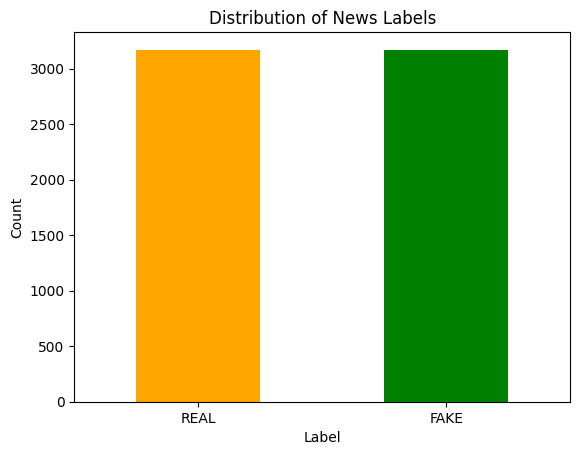

In [271]:
import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind='bar', color=['orange', 'green'])
plt.title('Distribution of News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Checking Text Lengths and Nulls

count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: content_length, dtype: float64


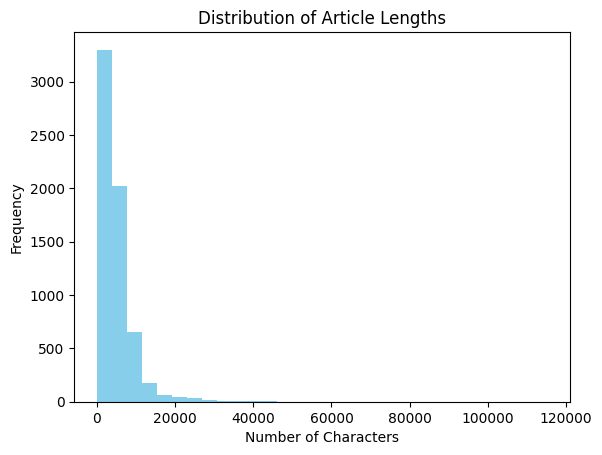

In [ ]:
data['content_length'] = data['text'].apply(len)
print(data['content_length'].describe())

plt.hist(data['content_length'], bins=30, color='skyblue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


### Looking at Sample Articles

In [ ]:
print("Sample FAKE News:\n", data[data['label'] == 'FAKE']['content'].iloc[0][:500])
print("\nSample REAL News:\n", data[data['label'] == 'REAL']['content'].iloc[0][:500])


Sample FAKE News:
 You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma

Sample REAL News:
 Kerry to go to Paris in gesture of sympathy U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.

Kerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to me

## Text Preprocessing

### Combine Title and Article Text

In [275]:
data['content'] = data['title'].fillna('') + ' ' + data['text'].fillna('')

### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = data['text']  # Accracy: 0.9582
# X = data['content']  # Accuracy: 0.9590
y = data['label'].map({'FAKE': 1, 'REAL': 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 ### Vectorization with TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    max_df=0.7,
    min_df=5,
    ngram_range=(1, 3),
    sublinear_tf=True,
    norm='l2', 
    smooth_idf=True,
    use_idf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Inspect Features

In [278]:
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print("Sample features:", vectorizer.get_feature_names_out()[:10])


Vocabulary size: 69578
Sample features: ['00' '00 pm' '000' '000 000' '000 000 pageviews' '000 according'
 '000 american' '000 american college' '000 americans' '000 bond']


### Output Matrix Shapes

In [279]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (5068, 69578)
X_test_tfidf shape: (1267, 69578)


## Modeling

### Model Selection: Linear Support Vector Classification

In [280]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

svc = LinearSVC()
calibrated_svc = CalibratedClassifierCV(svc)
calibrated_svc.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(estimator=LinearSVC())

### Making Predictions

In [ ]:
y_proba = calibrated_svc.predict_proba(X_test_tfidf)
y_pred = calibrated_svc.predict(X_test_tfidf)

### Model Evaluation

In [282]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['REAL', 'FAKE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9590
Classification Report:
               precision    recall  f1-score   support

        REAL       0.96      0.96      0.96       634
        FAKE       0.96      0.96      0.96       633

    accuracy                           0.96      1267
   macro avg       0.96      0.96      0.96      1267
weighted avg       0.96      0.96      0.96      1267

Confusion Matrix:
 [[608  26]
 [ 26 607]]


### Visualization of Confusion Matrix

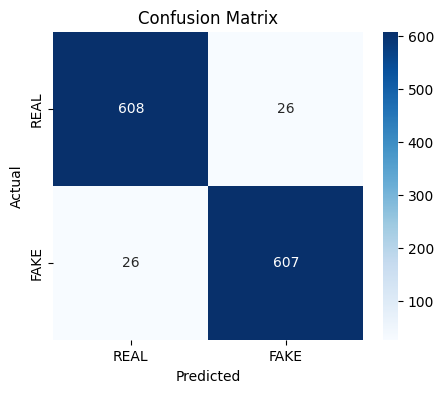

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Train vs Test Set Performance

In [284]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on train set
y_train_pred = calibrated_svc.predict(X_train_tfidf)

print("=== TRAIN SET ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred, target_names=['REAL', 'FAKE']))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# Predict on test set
y_test_pred = calibrated_svc.predict(X_test_tfidf)

print("\n=== TEST SET ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=['REAL', 'FAKE']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

=== TRAIN SET ===
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        REAL       1.00      1.00      1.00      2537
        FAKE       1.00      1.00      1.00      2531

    accuracy                           1.00      5068
   macro avg       1.00      1.00      1.00      5068
weighted avg       1.00      1.00      1.00      5068

Confusion Matrix:
 [[2537    0]
 [   0 2531]]

=== TEST SET ===
Accuracy: 0.9589581689029203

Classification Report:
               precision    recall  f1-score   support

        REAL       0.96      0.96      0.96       634
        FAKE       0.96      0.96      0.96       633

    accuracy                           0.96      1267
   macro avg       0.96      0.96      0.96      1267
weighted avg       0.96      0.96      0.96      1267

Confusion Matrix:
 [[608  26]
 [ 26 607]]
